## Configuração

### Utilizando GPU

Vamos garantir que temos acesso à GPU.

In [ ]:
!nvidia-smi

Thu Apr 17 12:38:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             49W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

**OBSERVAÇÃO:** Para facilitar o gerenciamento de conjuntos de dados, imagens e modelos, criamos uma constante `HOME`.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Instalação do YOLO11 via Ultralytics

In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 41.3/112.6 GB disk)


## Fine-tune do YOLO11 em conjunto de dados personalizado

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

# project = rf.workspace("workspace-zqssx").project("knife-dataset-new")
# version = project.version(1)
# dataset = version.download("yolov11")

project = rf.workspace("tec5").project("my-first-project-w16dm")
version = project.version(1)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to My-First-Project-1 in yolov11:: 100%|██████████| 10130/10130 [00:01<00:00, 5694.09it/s]


## Treinamento personalizado

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=100 batch=32 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 451MB/s]
New https://pypi.org/project/ultralytics/8.3.110 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/My-First-Project-1/data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnost

**NOTA:** Os resultados do treinamento concluído são salvos em `{HOME}/runs/detect/train/`. Vamos examinar isso.

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    train_batch1.jpg
confusion_matrix_normalized.png			    train_batch2.jpg
confusion_matrix.png				    train_batch9990.jpg
events.out.tfevents.1744893717.3a68a2c2c7d4.1265.0  train_batch9991.jpg
F1_curve.png					    train_batch9992.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
P_curve.png					    val_batch1_labels.jpg
PR_curve.png					    val_batch1_pred.jpg
R_curve.png					    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


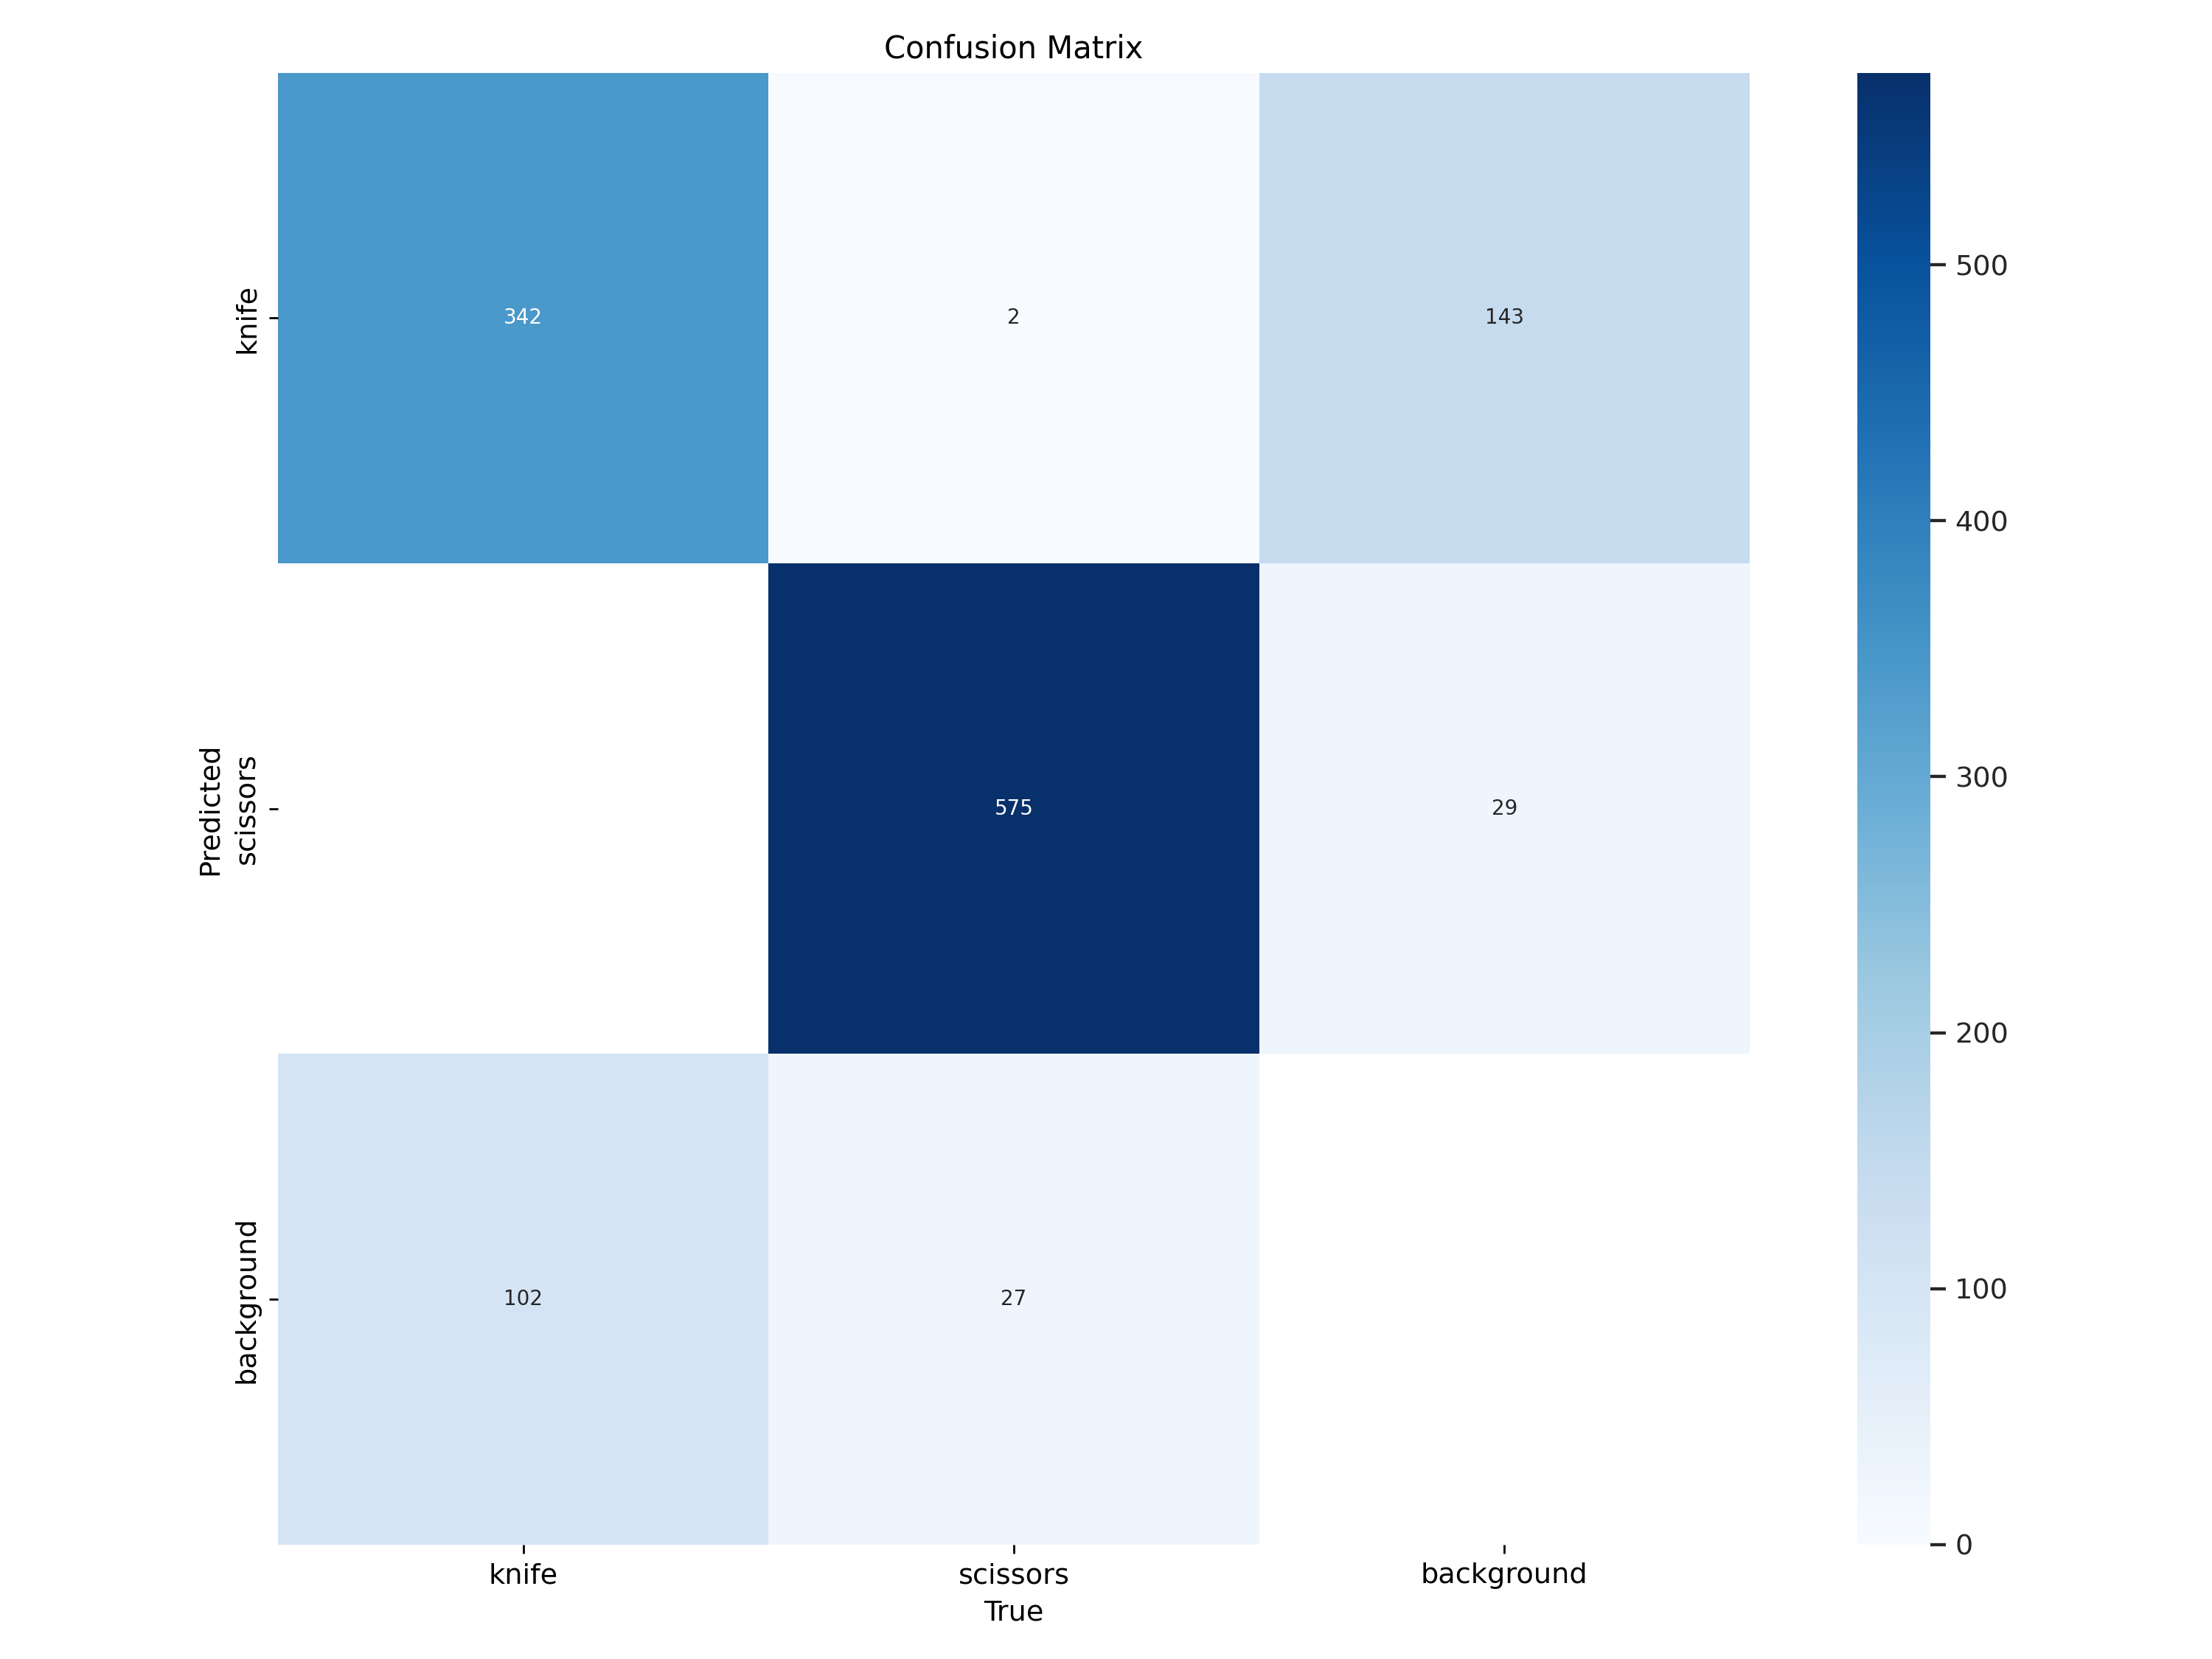

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

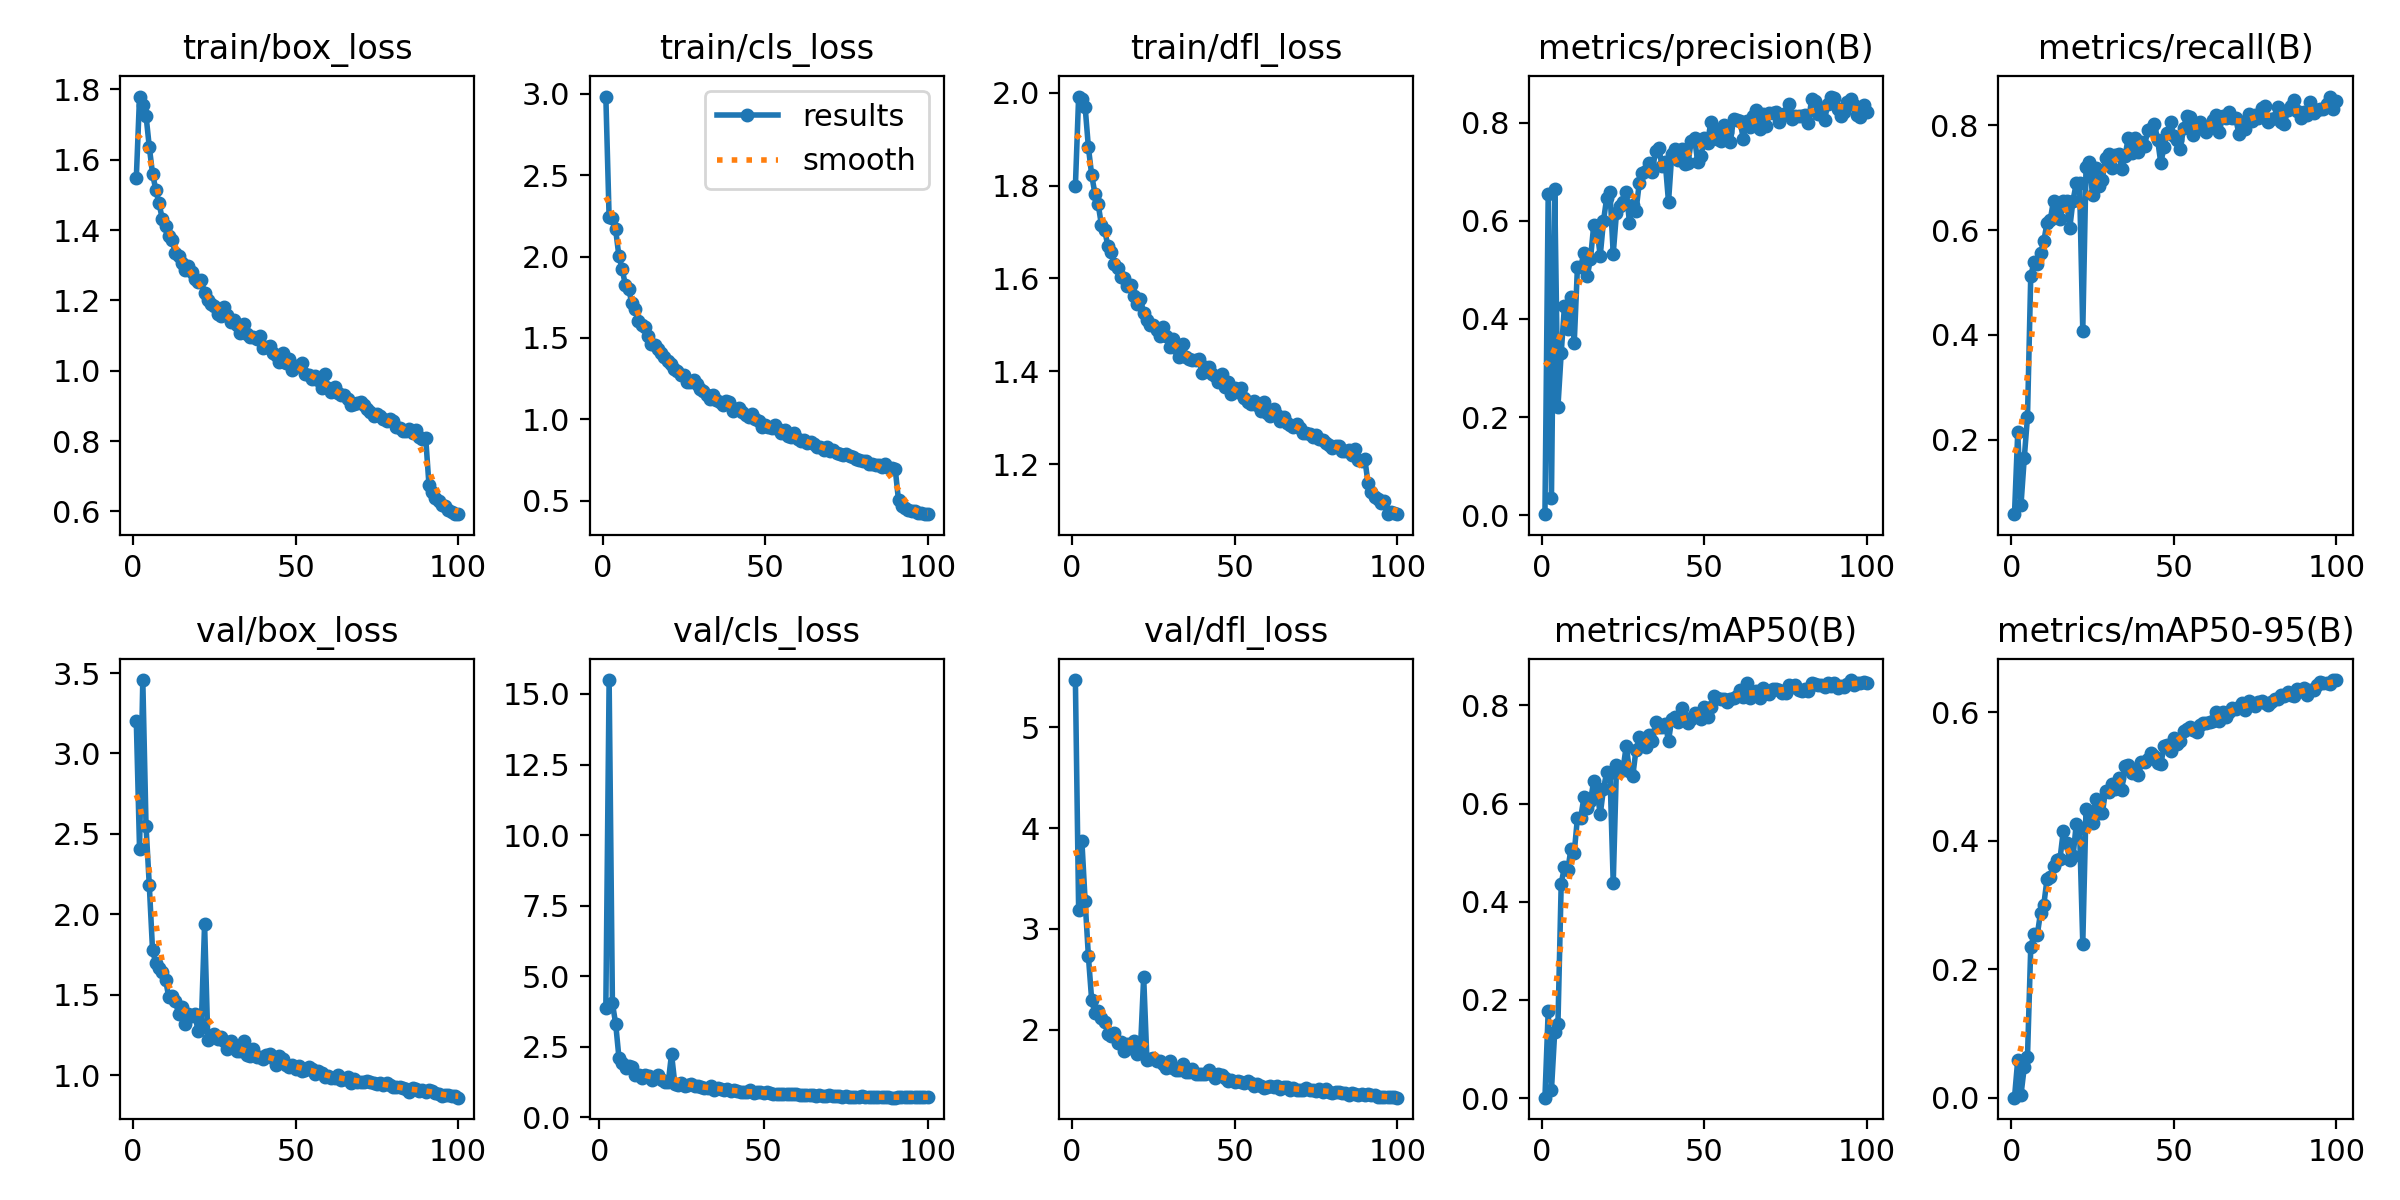

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

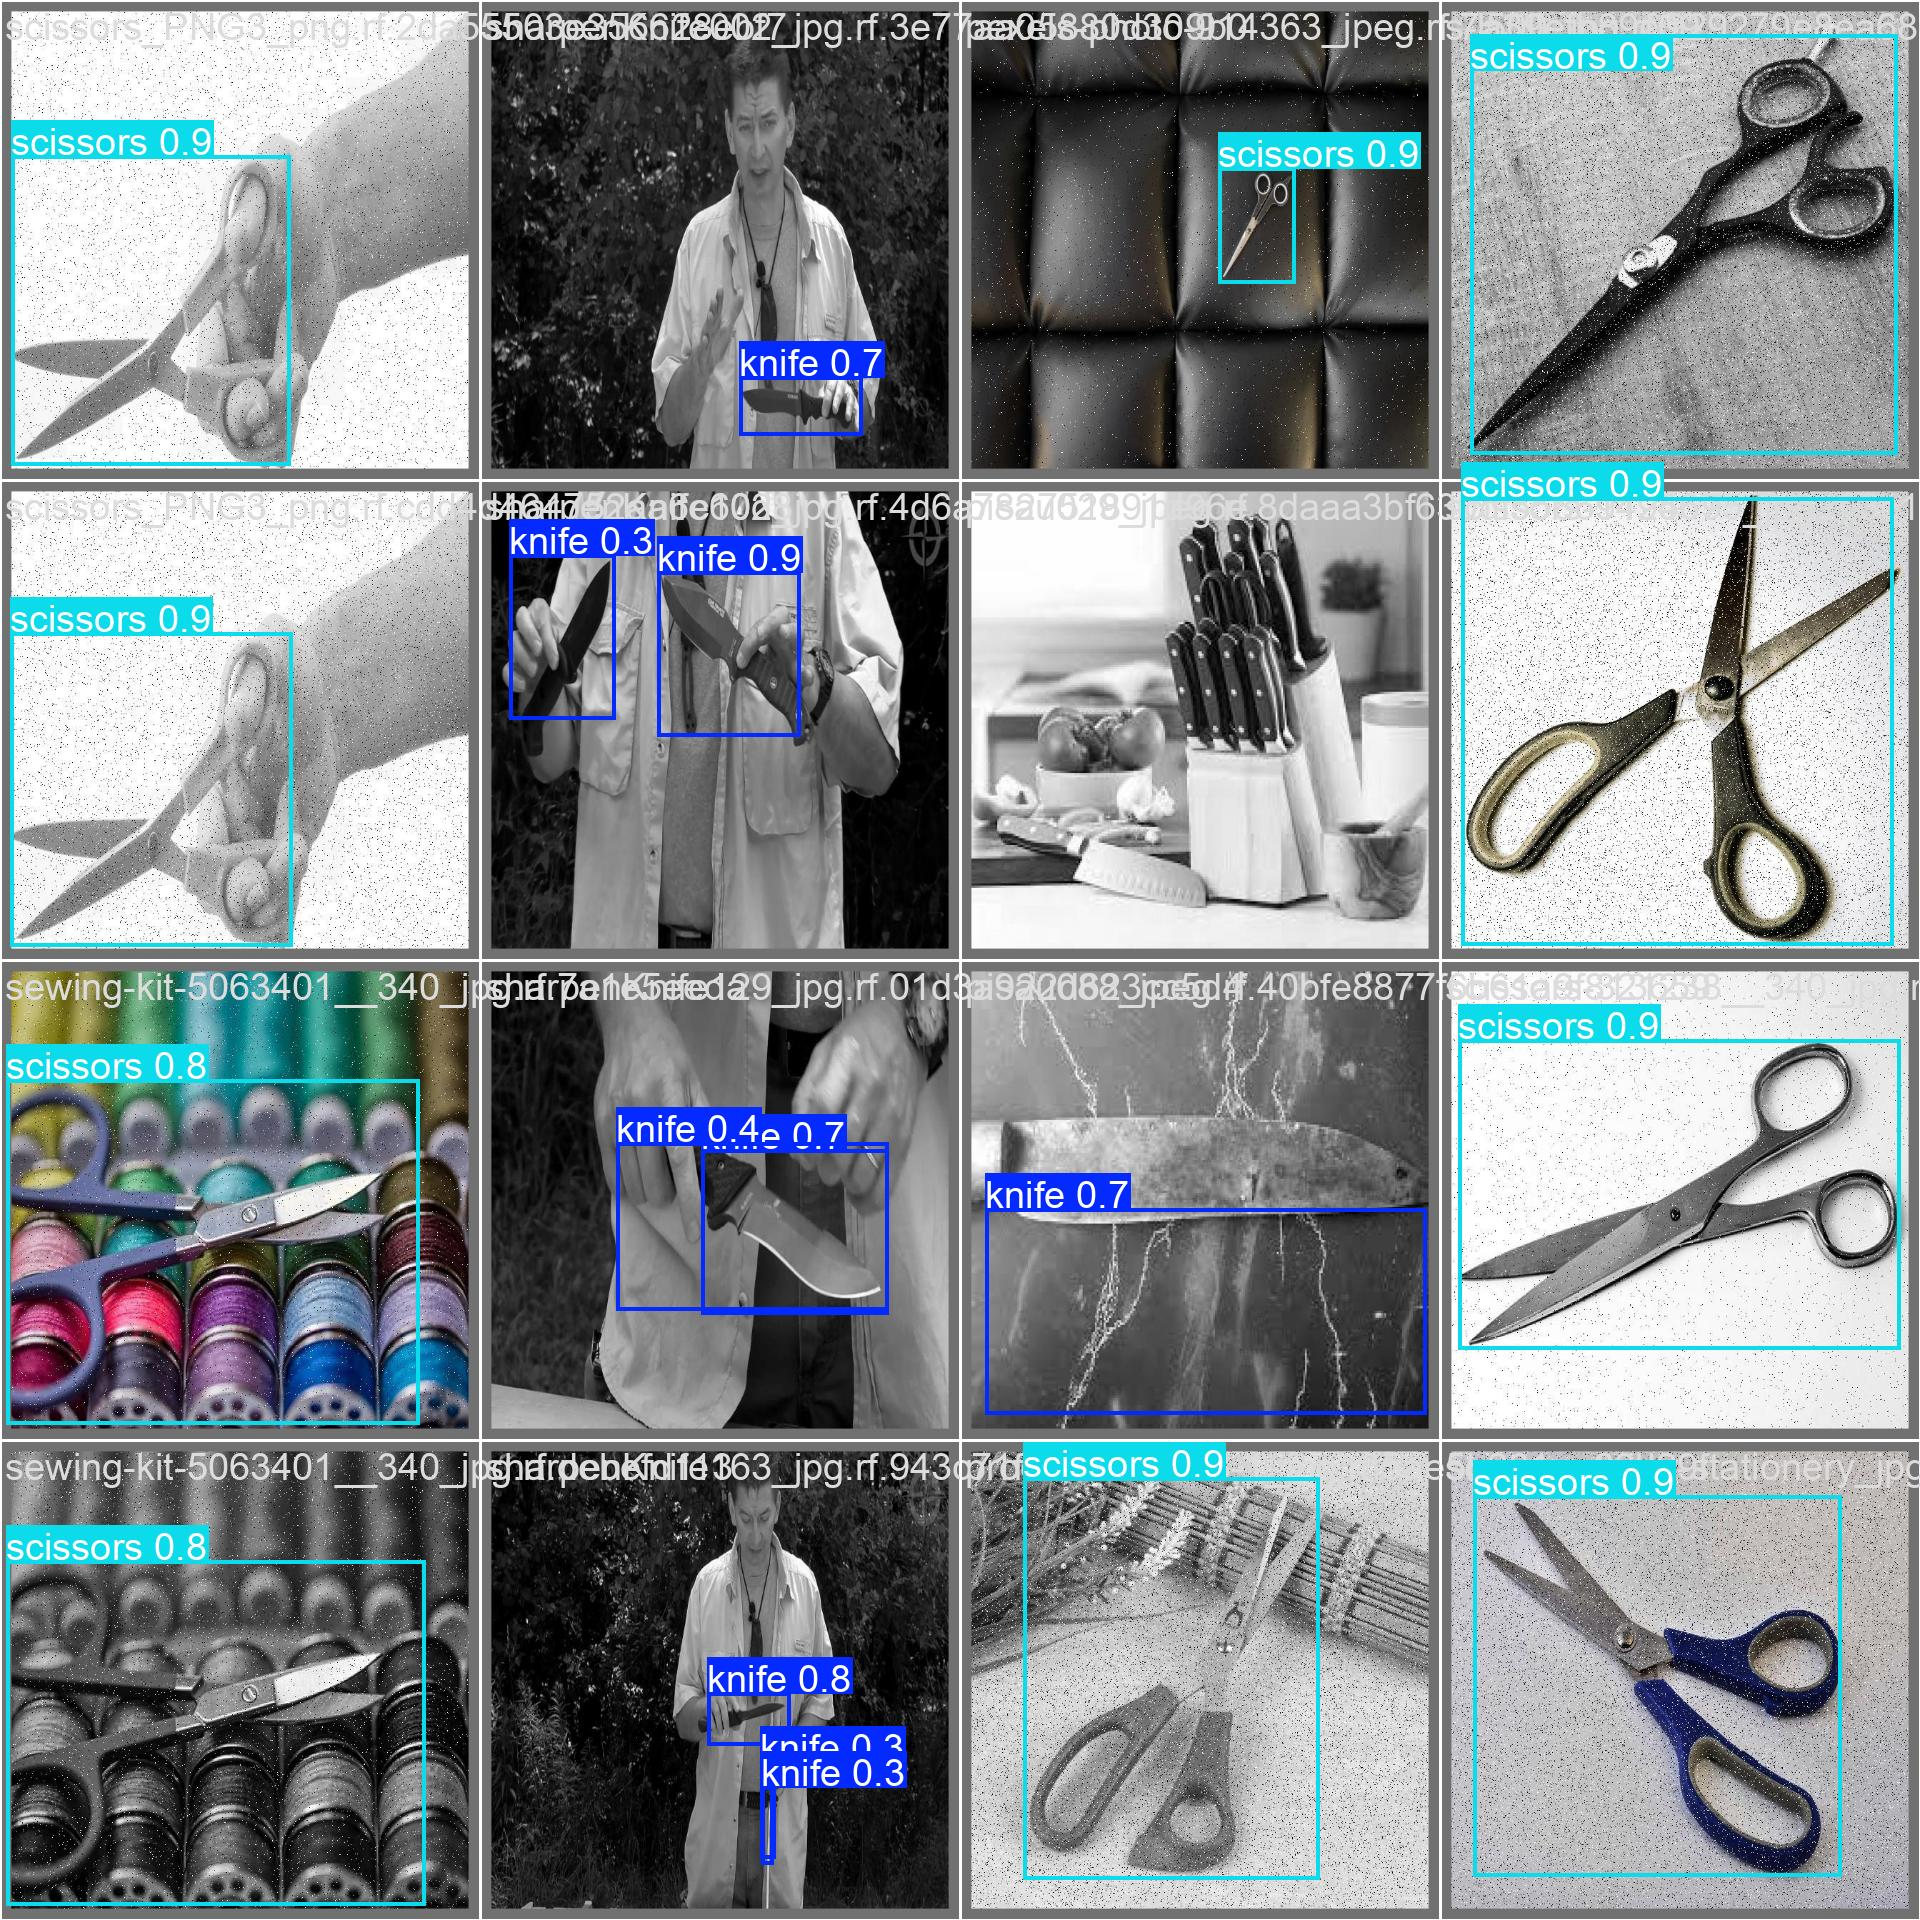

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validando o modelo fine-tuned

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/My-First-Project-1/valid/labels.cache... 1013 images, 86 backgrounds, 0 corrupt: 100% 1013/1013 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 179, len(boxes) = 1048. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 64/64 [00:05<00:00, 11.43it/s]
                   all       1013       1048      0.838      0.832      0.849       0.65
                 knife        405        444      0.705      0.715      0.718      0.436
              scissors        522        604      0.971      0.948       0.98      0.863
Speed: 0.3

## Inferência com o modelo customizado

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

image 1/505 /content/datasets/My-First-Project-1/test/images/-037-680x630_jpg.rf.71abed7bd1ace3f4549b4b1507a73024.jpg: 640x640 1 scissors, 11.4ms
image 2/505 /content/datasets/My-First-Project-1/test/images/-4717585_jpg.rf.f6d51ca77262a342039fd7592047a39b.jpg: 640x640 1 scissors, 11.0ms
image 3/505 /content/datasets/My-First-Project-1/test/images/-scissors-97429168_jpg.rf.18b6a1eee7d15aa4c7f9be9fe20a3493.jpg: 640x640 2 scissorss, 11.7ms
image 4/505 /content/datasets/My-First-Project-1/test/images/-scissors-97429168_jpg.rf.bad8a48746ff486a87645ec94d14fd66.jpg: 640x640 2 scissorss, 10.0ms
image 5/505 /content/datasets/My-First-Project-1/test/images/05adc4e90029b21ec78287e50e7a7b4c_jpg.rf.209c67985b6e076d6e0af95d0fa29e2e.jpg: 640x640 1 scissors, 9.8ms
image 6/505 /content/datasets/My-First-Project-1/test/images/

**NOTA:** Visualizando alguns resultados.

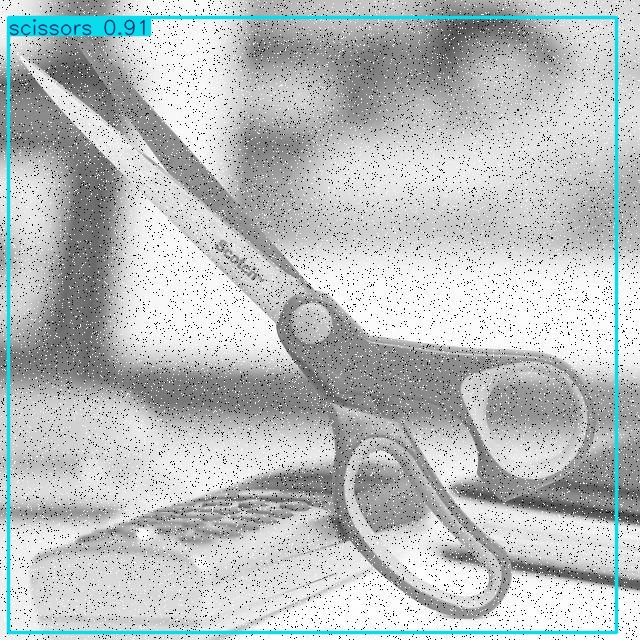

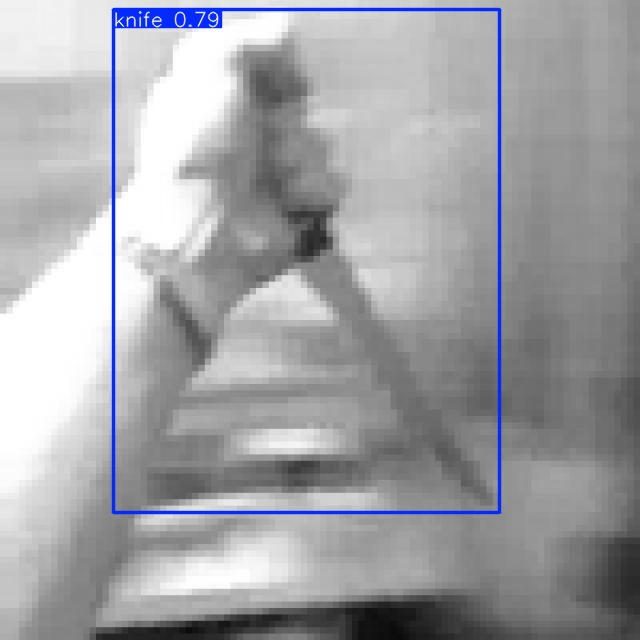

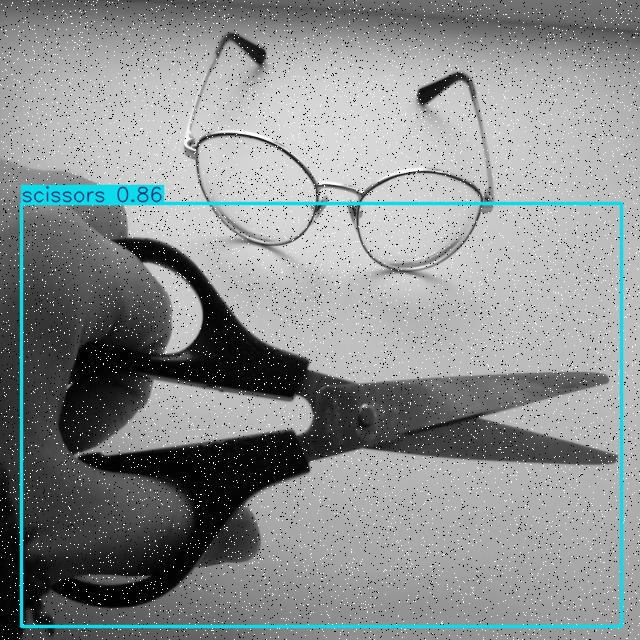

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Deploy modelo no Roboflow

Após concluir o treinamento do seu modelo YOLOv11, você terá um conjunto de pesos treinados pronto para uso. Esses pesos estarão na pasta `/runs/detect/train/weights/best.pt` do seu projeto. Você pode enviar os pesos do seu modelo para o Roboflow Deploy para usá-los em nossa infraestrutura infinitamente escalável.

A função `.deploy()` no [pacote pip do Roboflow](https://docs.roboflow.com/python) agora suporta o upload de pesos YOLOv11.

In [ ]:
project = rf.workspace("fiaphackathon").project("knife-dataset-hackathon-fiap")
# version = project.version(1)

project.deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

loading Roboflow workspace...
loading Roboflow project...


AttributeError: 'Project' object has no attribute 'deploy'

In [ ]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)
